In [1]:
import numpy as np
import pyvista as pv
import numpy as np
from toolbox.load_data import read_off, read_npy
from toolbox.rescale import rescale
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mesh_utils import vectorized_is_point_inside_mesh

In [2]:
N = 100
t = np.linspace(0, 1, N)
space = np.stack(np.meshgrid(t, t, t), axis=-1).reshape(N**3, -1)
space3d = np.stack(np.meshgrid(t, t, t), axis=-1)

In [3]:
path_to_data = "../../data/"

fignames = ["duck", "torus"]
fig_data = []
for figname in fignames:
    try :
        fig_data.append(read_npy(path_to_data, figname))
    except FileNotFoundError:
        arr_verts, arr_faces = read_off(path_to_data, figname)
        arr_verts = rescale(arr_verts, 0.03, 0.97)
        fig_data.append(vectorized_is_point_inside_mesh(space, arr_verts, arr_faces).reshape(N, N, N).astype(np.float32))

In [80]:
q = 5
t = np.linspace(0,1,q)
W = np.array([[s,1-s] for s in t])

In [81]:
from toolbox.blur_kernel import imgaussian
from toolbox.apply_3d_func import apply_3d_func
mu = N/25
blur = lambda x: imgaussian(x, mu, mu*50)
Kv = lambda x: apply_3d_func(blur, x)

In [82]:
from tqdm import tqdm

def convolutional_barycenter(mus, alphas, area_weights, kernel, kernel_transpose, entropy_limit):
    n_iter = 1500
    tol = 1e-3
    v = np.ones(mus.shape)
    alphas = alphas / sum(alphas)
    if area_weights is None:
        area_weights = np.ones(mus.shape[1])
    if kernel_transpose is None:
        kernel_transpose = kernel
    barycenter = np.ones(mus.shape[1])
    for i in range(n_iter):
        old_barycenter = barycenter
        w = mus / (kernel_transpose(v * area_weights))
        d = v * kernel(w * area_weights)
        d[d<1e-100] = 1e-100
        barycenter = np.exp(np.sum(alphas.reshape(-1, 1) * np.log(d), axis=0))
        #entropy = -np.sum(area_weights*(barycenter*np.log(barycenter)))
        v = v*barycenter/d
        change = np.sum(np.abs(old_barycenter-barycenter) * area_weights)
        print(change)
        if np.isnan(change) or (i > 2 and change < tol):
            return barycenter
    return barycenter

In [ ]:
#from toolbox.convolutional_barycenter import convolutional_barycenter

bar = []
for w in tqdm(W):
    w = w/sum(w)
    entropy_limit = None
    Hv = np.array([dist.flatten()/dist.sum() for dist in fig_data])
    B = convolutional_barycenter(Hv, w, None, Kv, None, entropy_limit)
    B = B.reshape(N, N, N)
    B = B/max(B.flatten())
    bar.append(B)

In [45]:
def find_neighbours(cloud,i,j,k):
    """
    for a point and a point cloud, computes number of neighbours (no diagonals)
    """
    res = 0
    res += cloud[i-1,j,k]
    res += cloud[i+1,j,k]
    res += cloud[i,j-1,k]
    res += cloud[i,j+1,k]
    res += cloud[i,j,k-1]
    res += cloud[i,j,k+1]
    return res

In [68]:
def delete_inside_points(cloud):
    """
    From a point cloud of shape (N,N,N), returns cloud w/o points inside, meaning ones with 6 neighbours
    """
    surface = cloud.copy()
    N = cloud.shape[0]
    indexes = []
    for i in range(1,N-1):
        for j in range(1,N-1):
            for k in range(1,N-1):
                neighbours = find_neighbours(cloud,i,j,k)
                if neighbours==6:
                    indexes.append((i,j,k))
    for i,j,k in indexes:
        surface[i,j,k] = False
    return surface

In [ ]:
bary = bar[2]
cloud0 = bary>0.1
cloud0 = delete_inside_points(cloud0)
#points_inside = (bary.reshape(N**3, -1) > 0.1).ravel()
points_inside = cloud0.reshape(N**3, -1).ravel()
x = space[points_inside][:, 0]
y = space[points_inside][:, 1]
z = space[points_inside][:, 2]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                           mode='markers',
                        )])
fig.show()

In [91]:
bary = bar[2]
cloud0 = bary>0.1
cloud0 = delete_inside_points(cloud0)
#points_inside = (bary.reshape(N**3, -1) > 0.1).ravel()
points_inside = cloud0.reshape(N**3, -1).ravel()
x = space[points_inside][:, 0]
y = space[points_inside][:, 1]
z = space[points_inside][:, 2]
# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
#                         mode='markers',
#                         )])
# fig.show()
points = np.array([x,y,z]).T
point_cloud = pv.PolyData(points)
mesh = point_cloud.reconstruct_surface(progress_bar=True)

Reconstructing surface: 100%|██████████[00:02<00:00]


In [104]:
arr_faces = mesh.faces.reshape(-1, 4)[:, 1:]
arr_verts = mesh.points

fig = go.Figure(data=[
    go.Mesh3d(
        x=arr_verts[:,0],
        y=arr_verts[:,1],
        z=arr_verts[:,2],
        i = arr_faces[:,0],
        j = arr_faces[:,1],
        k = arr_faces[:,2],
        color='cyan', 
    ),
])
fig.show()

In [106]:
len(bary)

100

In [105]:
for i in range(5):
    bary = bar[i]
    cloud0 = bary>0.1
    cloud0 = delete_inside_points(cloud0)
    #points_inside = (bary.reshape(N**3, -1) > 0.1).ravel()
    points_inside = cloud0.reshape(N**3, -1).ravel()
    x = space[points_inside][:, 0]
    y = space[points_inside][:, 1]
    z = space[points_inside][:, 2]
    # fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
    #                         mode='markers',
    #                         )])
    # fig.show()
    points = np.array([x,y,z]).T
    point_cloud = pv.PolyData(points)
    mesh = point_cloud.reconstruct_surface(progress_bar=True)

    arr_faces = mesh.faces.reshape(-1, 4)[:, 1:]
    arr_verts = mesh.points

    fig = go.Figure(data=[
        go.Mesh3d(
            x=arr_verts[:,0],
            y=arr_verts[:,1],
            z=arr_verts[:,2],
            i = arr_faces[:,0],
            j = arr_faces[:,1],
            k = arr_faces[:,2],
            color='cyan', 
        ),
    ])
    fig.show()

Reconstructing surface: 100%|██████████[00:01<00:00]


Reconstructing surface: 100%|██████████[00:01<00:00]


Reconstructing surface: 100%|██████████[00:01<00:00]


Reconstructing surface: 100%|██████████[00:01<00:00]


Reconstructing surface: 100%|██████████[00:01<00:00]


Reconstructing surface: 100%|██████████[00:01<00:00]
c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.



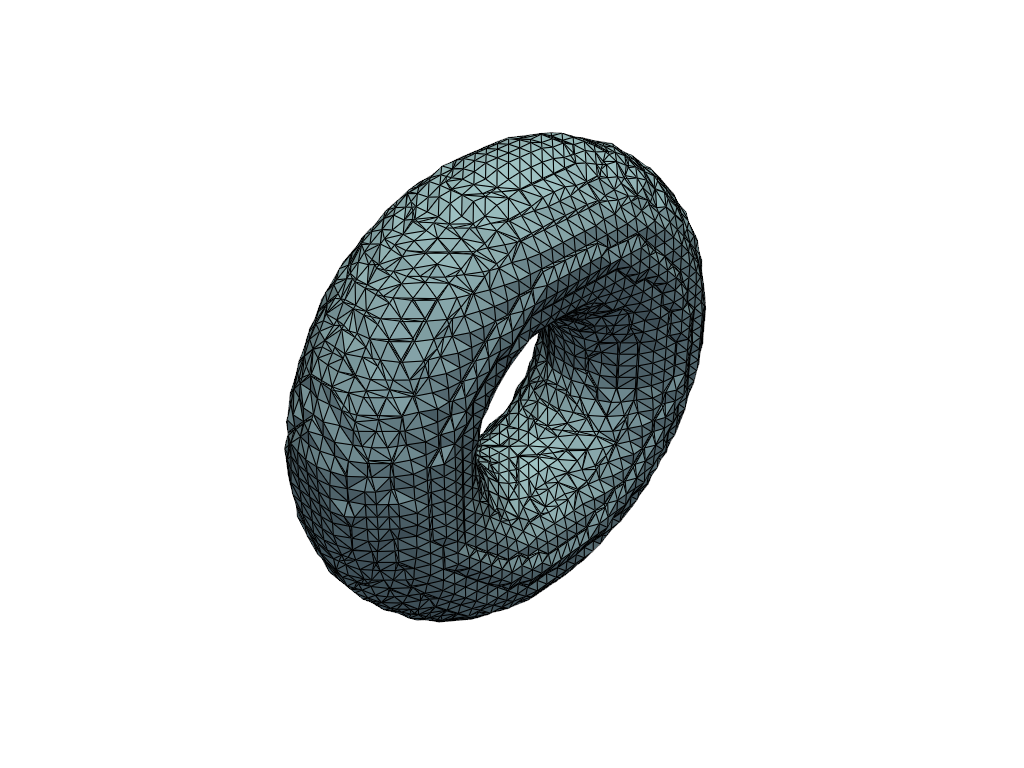

Reconstructing surface: 100%|██████████[00:01<00:00]
c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.



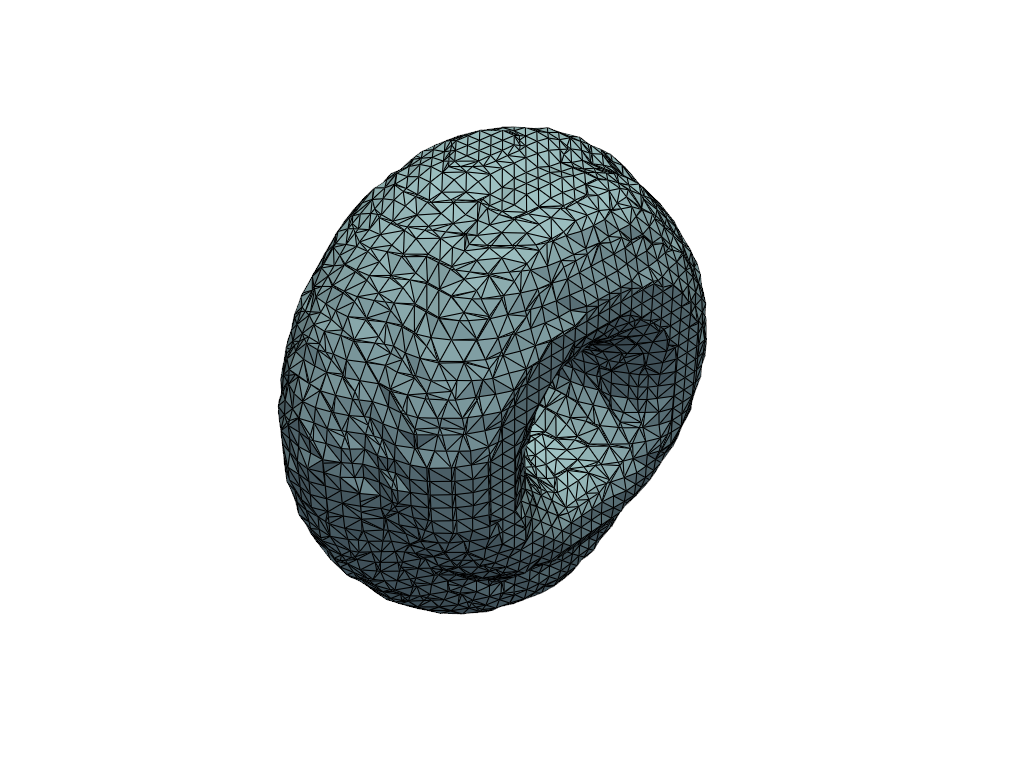

Reconstructing surface: 100%|██████████[00:01<00:00]
c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.



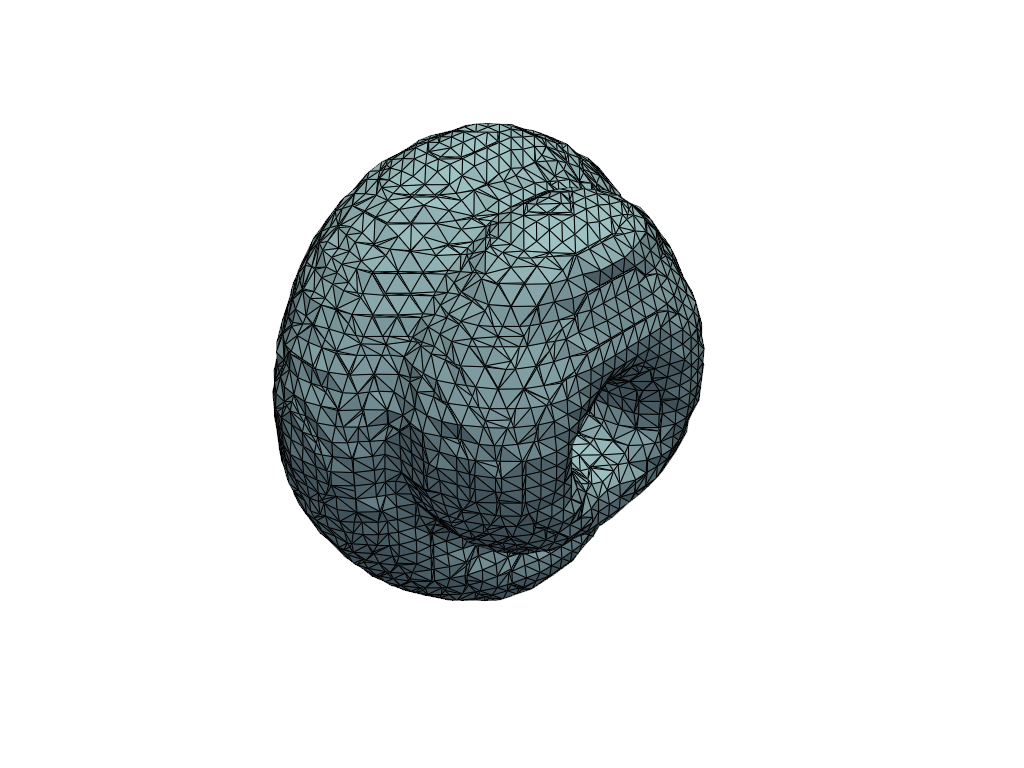

Reconstructing surface: 100%|██████████[00:01<00:00]
c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.



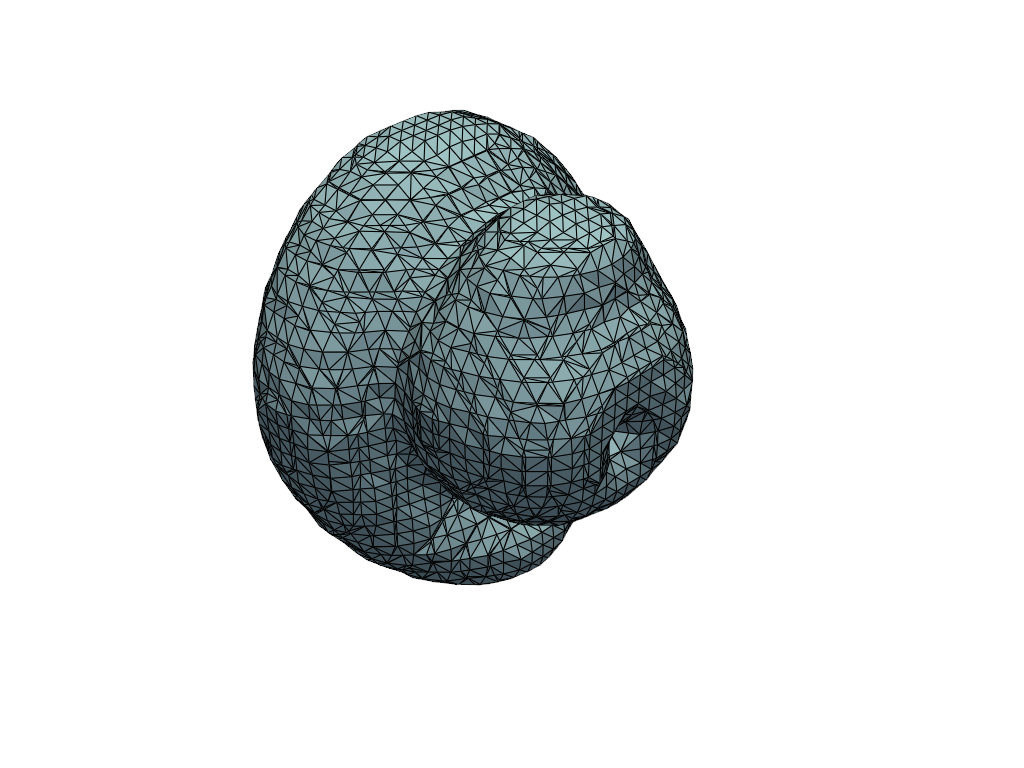

Reconstructing surface: 100%|██████████[00:01<00:00]
c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nael3\Documents\ENSAE\3A\ENSAE\Advanced ML\Project\Convolutionnal-Wasserstein-Distances\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.



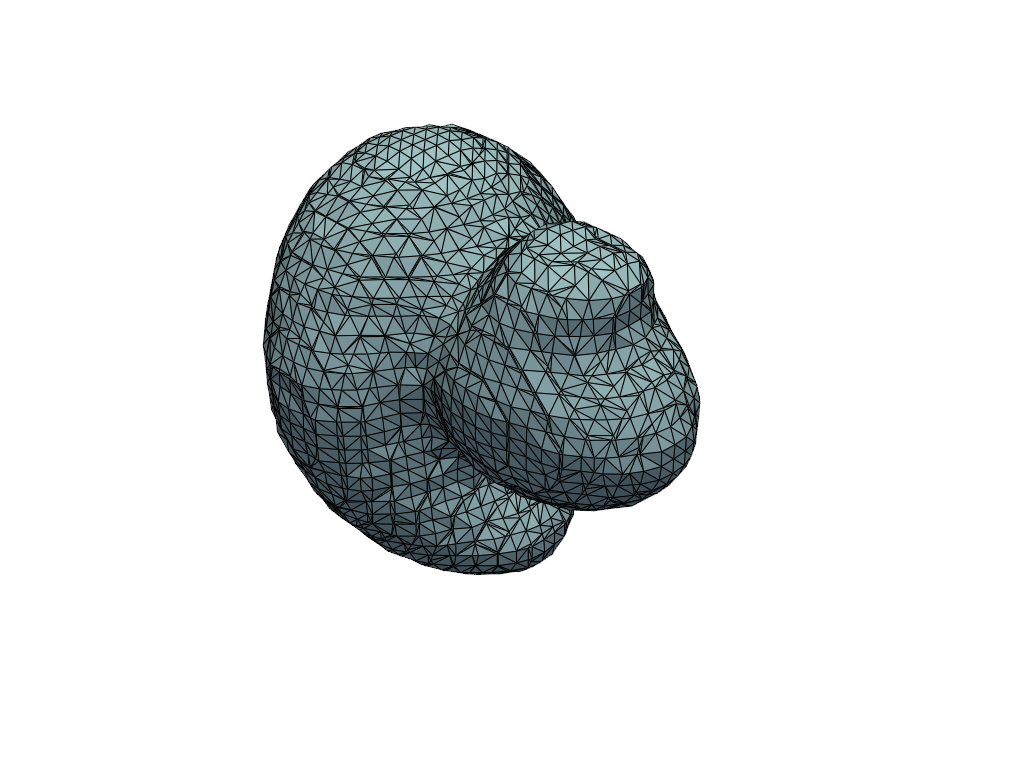

In [90]:
for i in range(5):
    bary = bar[i]
    cloud0 = bary>0.1
    cloud0 = delete_inside_points(cloud0)
    #points_inside = (bary.reshape(N**3, -1) > 0.1).ravel()
    points_inside = cloud0.reshape(N**3, -1).ravel()
    x = space[points_inside][:, 0]
    y = space[points_inside][:, 1]
    z = space[points_inside][:, 2]
    # fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
    #                         mode='markers',
    #                         )])
    # fig.show()
    points = np.array([x,y,z]).T
    point_cloud = pv.PolyData(points)
    mesh = point_cloud.reconstruct_surface(progress_bar=True)
    pl = pv.Plotter()
    pl.add_mesh(mesh, color=True, show_edges=True)
    pl.show()

In [35]:
space3d.shape

(100, 100, 100, 3)

In [13]:
points_inside = (bary.reshape(N**3, -1) > 0.1).ravel()

In [18]:
points_inside.shape

(1000000,)